In [1]:
import pandas as pd
import numpy as np
import os
#Read the data from GitHub directly
url = "https://github.com/renatoquiliche/PaperCienciaDados-PunoPeru/blob/main/Databases/peru_2019.csv?raw=true"

data_puno = pd.read_csv(url)


In [2]:
# Set the random seed for reproductible results
np.random.seed(0)

Y = data_puno["disasters_risk"]

In [3]:
from preprocessing import preprocessing
x = preprocessing(data_puno, umbral=0.02)


Old data dimension (1106, 86)
Features removed : 13
New data dimension (1106, 73)


In [4]:

# Init the grid search cross-validation on RFC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import matthews_corrcoef, make_scorer, accuracy_score, f1_score, roc_curve
#from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# I define here the NPV metric
def neg_pred_value(y_true,y_predicted):
    cm = confusion_matrix(y_true, y_predicted)
    if (cm[1][0]+cm[0][0])==0:
        neg_pred_value=0
    else:
        neg_pred_value = cm[0][0]/(cm[1][0]+cm[0][0])
    return neg_pred_value


In [46]:
from scipy.stats import uniform, randint

def RFCexperiments(K_folds, Repeats, n_iter):
    # Cross-validation method
    cv = RepeatedStratifiedKFold(n_splits=K_folds, n_repeats=Repeats, random_state=0)
    
    # Hyperparameter grid for RFC
    param_grid = {'criterion': ['gini', 'entropy'],
                  'max_depth': randint(3,8),
                  'min_samples_split': uniform(0, 0.4),
                  'min_samples_leaf': uniform(0, 0.05),
                  'n_estimators': [10, 100, 200, 250, 450],
                  'max_features': uniform(0.05,0.15)}
    
    # I define the model here
    RFC = RandomForestClassifier(random_state=0, n_jobs=-1, bootstrap=True)
    scoring = {"AUC": "roc_auc"
               , "Accuracy": make_scorer(accuracy_score)
               , "F1-Score": "f1"
               , "MCC": make_scorer(matthews_corrcoef)
               , "NPV": make_scorer(neg_pred_value)}
    
    #Test CV
    search_ddnn = RandomizedSearchCV(random_state=0, estimator = RFC, param_distributions=param_grid
                                     , scoring=scoring, cv=cv, n_jobs=-1, refit="MCC", verbose=4, n_iter=n_iter)
    results = search_ddnn.fit(x, Y)
    return results


In [47]:
import time
start = time.time()

K = 10
Repeats = 2
n_iter = 2000
RFC_results =  RFCexperiments(K, Repeats, n_iter)

Total_time = (time.time() - start)
print("Training time: ", Total_time, " seconds")


Fitting 20 folds for each of 2000 candidates, totalling 40000 fits
Training time:  2347.521462917328  seconds


In [48]:

pd.DataFrame(RFC_results.cv_results_).to_csv("..\Resultados\RFC\RFC_results.csv")

In [49]:
cutoff = round(n_iter*0.05)

results_dataset = pd.DataFrame(RFC_results.cv_results_)
sorted_results = results_dataset.sort_values(by=["rank_test_MCC"])

# Select the 5% best MCC
step4 = sorted_results.iloc[0:cutoff,:]

# Select the best NPV over 5% best MCC
step5 = step4.sort_values(by=["rank_test_NPV"])
print(step4["mean_test_MCC"].iloc[0], step4["mean_test_NPV"].iloc[0])
print(step5["mean_test_MCC"].iloc[0], step5["mean_test_NPV"].iloc[0])

print("Change in MCC: ", 100*(step5["mean_test_MCC"].iloc[0]-step4["mean_test_MCC"].iloc[0])/(step4["mean_test_MCC"].iloc[0]))
print("Change in NPV: ", 100*(step5["mean_test_NPV"].iloc[0]-step4["mean_test_NPV"].iloc[0])/(step4["mean_test_NPV"].iloc[0]))
print("Percentil 5 cutoff: ", cutoff)

0.5489832938247442 0.8053459404113605
0.5425328979551028 0.817712549664031
Change in MCC:  -1.174971249981345
Change in NPV:  1.5355648587926953
Percentil 5 cutoff:  100


In [50]:
display(step4[["rank_test_MCC", "rank_test_NPV"]])
display(step5[["rank_test_MCC", "rank_test_NPV"]])

print("Parameters before NPV maximization: ")
display(step4["params"].iloc[0])

print("Parameters after NPV maximization: ")
display(step5["params"].iloc[0])

,rank_test_MCC,rank_test_NPV
1385,1,104
269,2,112
1835,3,113
1346,4,127
799,5,138
...,...,...
1332,96,810
1096,97,234
265,98,399
79,99,411


,rank_test_MCC,rank_test_NPV
116,10,41
663,93,45
1968,75,103
1385,1,104
929,54,107
...,...,...
709,66,526
1972,92,572
541,90,603
549,100,608


Parameters before NPV maximization: 


{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 0.05496909943094376,
 'min_samples_leaf': 0.001312276945551858,
 'min_samples_split': 0.08541723176860612,
 'n_estimators': 100}

Parameters after NPV maximization: 


{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 0.09306788925262513,
 'min_samples_leaf': 0.009454809891821568,
 'min_samples_split': 0.0464393348575646,
 'n_estimators': 10}

<AxesSubplot:xlabel='Repeat', ylabel='NPV'>

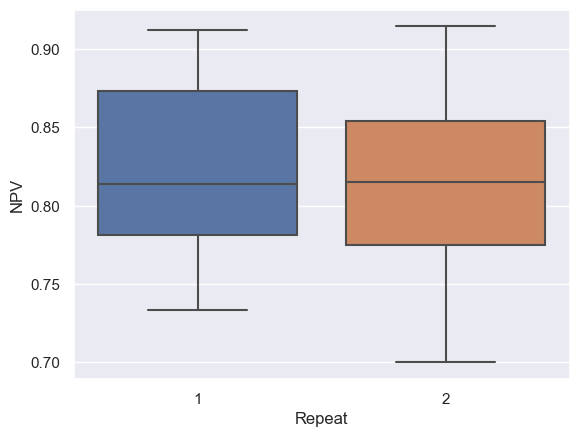

In [51]:
import seaborn as sns

NPV_repeats = {"Repeat1": [], "Repeat2": []}
for i in range(10):
    NPV_repeats["Repeat1"].append(f'split{i}_test_NPV')

for i in range(10,20):
    NPV_repeats["Repeat2"].append(f'split{i}_test_NPV')    

NPV = pd.DataFrame()

NPV_repeats1 = pd.concat([step5.iloc[0:1].T.loc[NPV_repeats["Repeat1"]].reset_index(), 
            pd.Series(np.ones(10).astype("int"))], axis=1, ignore_index=True)

NPV_repeats2 = pd.concat([step5.iloc[0:1].T.loc[NPV_repeats["Repeat2"]].reset_index(), 
            pd.Series(np.ones(10).astype("int"))+1], axis=1, ignore_index=True)            


NPV_repeats = pd.concat([NPV_repeats1, NPV_repeats2], axis=0)
NPV_repeats.columns = ["experiment", "NPV", "Repeat"]

sns.set_theme()
sns.boxplot(data=NPV_repeats, y="NPV", x="Repeat")


<AxesSubplot:xlabel='param_min_samples_split', ylabel='mean_test_MCC'>

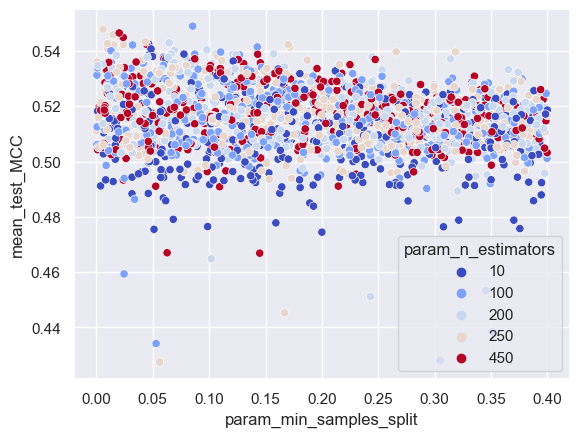

In [68]:
import seaborn as sns
import pandas as pd

results_dataset = pd.read_csv("..\Resultados\RFC\RFC_results.csv")

color_dict = dict({'sqrt':'red',
                  'log2':'green'})

sns.scatterplot(data=results_dataset, x="param_min_samples_split", y="mean_test_MCC", hue="param_n_estimators"
                ,palette="coolwarm")

In [75]:
results_dataset[["mean_test_MCC","param_max_depth"]].corr()

,mean_test_MCC,param_max_depth
mean_test_MCC,1.000000,-0.019979
param_max_depth,-0.019979,1.000000
